In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import matplotlib.pyplot as plt
import triton
import triton.language as tl
import triton.testing

In [2]:
class TorchAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_model = d_model
        self.head_dim = d_model // num_heads

        # Initialise Projection matrices
        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k = nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        # Output Projection
        self.W_o = nn.Linear(d_model, d_model, bias = False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask = None):
        # x is of shape [batch_size, seq_len, d_model]
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x) # [batch_size, seq_len, d_model]
        k = self.W_k(x) # [batch_size, seq_len, d_model]
        v = self.W_v(x) # [batch_size, seq_len, d_model]

        # Reshaping for multi-head attention
        # [batch_size, seq_len, d_model] -> [batch_size, seq_len, num_heads, head_dim]
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # [batch_size, seq_len, num_heads, head_dim] -> [batch_size, num_heads, seq_len, head_dim]
        q = q.transpose(1,2)
        k = k.transpose(1,2)
        v = v.transpose(1,2)

        # Computing attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim) # [batch_size, num_heads, seq_len, seq_len]

        # Mask for causal attention
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        # Softmax to get attention weights
        # [batch_size, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scores, dim = -1)
        # Softmax along dim = -1 to determine how much attention along each key dimension

        # Applying dropout to attention weights
        attention_weights = self.dropout(attention_weights)

        # Applying attention weights to valyues
        # [batch_size, num_heads, seq_len, head_dim]
        context = torch.matmul(attention_weights, v)

        # Concatenating heads
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, num_heads, head_dim]
        context = context.transpose(1, 2)
        # [batch_size, num_heads, seq_len, head_dim] -> [batch_size, seq_len, d_model]
        context = context.contiguous().view(batch_size, seq_len, self.d_model)

        # Output projection
        output = self.W_o(context)

        return output


### Creating causal mask

In [3]:
def create_causal_mask(seq_len):
    # Lower tringular matrix so that query tokens dont have access to keys that come after them in the sequence
    mask = torch.tril(torch.ones((seq_len, seq_len)))

    return mask.unsqueeze(0).unsqueeze(0) # [1, 1, seq_len, seq_len]

In [4]:
# benchmark_and_analyze()

### Naive triton implementation

In [5]:
@triton.jit
def attention_kernel(
    q_ptr, k_ptr, v_ptr, o_ptr,
    batch_size, seq_len, num_heads, head_dim,
    q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
    k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
    v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
    o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
    scale, # 1 / square_root(d_k)
    BLOCK_SIZE: tl.constexpr
    ):

    batch_idx = tl.program_id(0)
    head_idx = tl.program_id(1)
    seq_idx =  tl.program_id(2)

    # Computing pointer offsets
    # Navigate to correct starting positions
    q_batch_offset = batch_idx * q_batch_stride
    q_head_offset = head_idx * q_head_stride
    q_seq_offset = seq_idx * q_seq_stride

    # No sequence offset for K and V since each query block will see all the key blocks
    k_batch_offset = batch_idx * k_batch_stride
    k_head_offset = head_idx * k_head_stride

    v_batch_offset = batch_idx * v_batch_stride
    v_head_offset = head_idx * v_head_stride

    o_batch_offset = batch_idx * o_batch_stride
    o_head_offset = head_idx * o_head_stride
    o_seq_offset = seq_idx * o_seq_stride

    # Loading query vector for this sequence position
    q_ptrs = q_ptr + q_batch_offset + q_head_offset + q_seq_offset + tl.arange(0, BLOCK_SIZE) * q_head_dim_stride # This loads data even if it is in non contiguous locations in memory
    q = tl.load(q_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

    # Initialise accumulator for weighted sum. One score for each key token
    acc = tl.zeros([BLOCK_SIZE], dtype = tl.float32)

    softmax_denominator = 0.0

    for k_seq_idx in range(seq_len):
        k_seq_offset = k_seq_idx * k_seq_stride
        k_ptrs =  k_ptr + k_batch_offset + k_head_offset + k_seq_offset + tl.arange(0, BLOCK_SIZE) * k_head_dim_stride
        k = tl.load(k_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

        score = tl.sum(q * k) * scale
        attention_weight = tl.exp(score)

        softmax_denominator += attention_weight

        v_seq_offset = k_seq_idx * v_seq_stride
        v_ptrs = v_ptr + v_batch_offset + v_head_offset + v_seq_offset + tl.arange(0, BLOCK_SIZE) * v_head_dim_stride

        v = tl.load(v_ptrs, mask = tl.arange(0, BLOCK_SIZE) < head_dim, other = 0.0)

        acc += attention_weight * v

    acc /= softmax_denominator

    output_ptrs = o_ptr + o_batch_offset + o_head_offset + o_seq_offset + tl.arange(0, BLOCK_SIZE) * o_head_dim_stride
    tl.store(output_ptrs, acc, mask = tl.arange(0, BLOCK_SIZE) < head_dim)



In [6]:
class TritonAttentionNaive(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k = nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        self.W_o = nn.Linear(d_model, d_model, bias = False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        o = torch.empty_like(q)

        scale = 1.0 / math.sqrt(self.head_dim)

        grid = (batch_size, self.num_heads, seq_len)

        block_size = 1
        while block_size < self.head_dim:
            block_size *= 2

        attention_kernel[grid](
            q, k, v, o,
            batch_size, seq_len, self.num_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            o.stride(0), o.stride(1), o.stride(2), o.stride(3),
            scale,
            BLOCK_SIZE = block_size
        )

        #  [batch_size, num_heads , seq_len, head_dim] -> [batch_size, seq_len, num_heads, head_dim] -> [batch_size, seq_len, d_model]
        o = o.permute(0,2,1,3).contiguous().view(batch_size, seq_len, self.d_model)
        o = self.W_o(o)

        return o

### Optimized Multi Head Attention using Triton

In [26]:
@triton.jit
def optimized_attention_kernel(
      q_ptr, k_ptr, v_ptr, o_ptr,
      batch_size, seq_len, num_heads, head_dim,
      q_batch_stride, q_head_stride, q_seq_stride, q_head_dim_stride,
      k_batch_stride, k_head_stride, k_seq_stride, k_head_dim_stride,
      v_batch_stride, v_head_stride, v_seq_stride, v_head_dim_stride,
      o_batch_stride, o_head_stride, o_seq_stride, o_head_dim_stride,
      scale, # 1 / square_root(d_k)
      BLOCK_SIZE_M: tl.constexpr, # Query Block Size
      BLOCK_SIZE_N: tl.constexpr, # Key Block Size
      BLOCK_SIZE_DMODEL : tl.constexpr, # Head Dimension Block Size,
      USE_CAUSAL_MASK : tl.constexpr
      ):

      batch_id = tl.program_id(0)
      head_id = tl.program_id(1)
      seq_start =  tl.program_id(2) * BLOCK_SIZE_M

      q_head_offset = head_id * q_head_stride
      k_head_offset = head_id * k_head_stride
      v_head_offset = head_id * v_head_stride

      q_batch_offset = batch_id * q_batch_stride
      k_batch_offset = batch_id * k_batch_stride
      v_batch_offset = batch_id * v_batch_stride

      o_head_offset = head_id * o_head_stride
      o_batch_offset = batch_id * o_batch_stride

      # Initializing accumulators
      m_i = tl.zeros([BLOCK_SIZE_M], dtype = tl.float32) - float('inf')
      l_i = tl.zeros([BLOCK_SIZE_M], dtype = tl.float32)
      acc = tl.zeros([BLOCK_SIZE_M, BLOCK_SIZE_DMODEL], dtype = tl.float32)

      q_block_mask = (seq_start + tl.arange(0, BLOCK_SIZE_M)) < seq_len

      # Processing key blocks
      for key_start in range(0, seq_len, BLOCK_SIZE_N):
          k_block_mask = (key_start + tl.arange(0, BLOCK_SIZE_N)) < seq_len

          if USE_CAUSAL_MASK:
            causal_mask = tl.arange(0, BLOCK_SIZE_M)[:, None] + seq_start >= tl.arange(0, BLOCK_SIZE_N)[None, :] + key_start # Process only tokens that occur before the given query

          # Loading Query Block [BLOCK_M, BLOCK_DMODEL]
          q_block_ptr = q_ptr + q_batch_offset + q_head_offset + (seq_start + tl.arange(0, BLOCK_SIZE_M)[:, None])* q_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * q_head_dim_stride

          q_block = tl.load(q_block_ptr, mask=q_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          # Loading Key Block [BLOCK_N, BLOCK_DMODEL]
          k_block_ptr = k_ptr + k_batch_offset + k_head_offset + (key_start + tl.arange(0,BLOCK_SIZE_N)[:, None])* k_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * k_head_dim_stride

          k_block = tl.load(k_block_ptr, mask=k_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          # Computing attention scores
          scores = tl.dot(q_block, tl.trans(k_block)) * scale

          if USE_CAUSAL_MASK:
            scores = tl.where(causal_mask, scores, float("-inf")) # This will be zeroed our during softmax

          # Stable Softmax Computation
          # 1. Computing Max for Numerical Stability
          m_ij = tl.max(scores, axis = 1)

          # 2. Updating Running Max
          m_i_new = tl.maximum(m_i, m_ij)

          # 3. Computing Exponentials with the updated max
          exp_scores = tl.exp(scores - m_i_new[:, None])

          # 4. Compute Scaling factor for previous computations
          alpha = tl.exp(m_i - m_i_new)

          # 5. Updating normalization factor
          l_i_new = alpha * l_i + tl.sum(exp_scores, axis = 1)

          # Loading Value block [BLOCK_N, BLOCK_DMODEL]
          v_block_ptr = v_ptr + v_batch_offset + v_head_offset + (key_start + tl.arange(0, BLOCK_SIZE_N)[:, None])* v_seq_stride + (key_start + tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * v_head_dim_stride

          v_block = tl.load(v_block_ptr, mask=k_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim), other=0.0)

          acc = acc * alpha[:, None] + tl.dot(exp_scores, v_block)

          m_i = m_i_new
          l_i = l_i_new

      acc /= l_i[:, None]

      o_block_ptr = o_ptr + o_batch_offset + o_head_offset + (seq_start + tl.arange(0, BLOCK_SIZE_M)[:, None])* o_seq_stride + (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :]) * o_head_dim_stride

      tl.store(o_block_ptr, acc, mask=q_block_mask[:, None] & (tl.arange(0, BLOCK_SIZE_DMODEL)[None, :] < head_dim))

In [27]:
class TritonAttentionOptimized(nn.Module):
    def __init__(self, d_model, num_heads, causal = False):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.causal = causal

        self.W_q = nn.Linear(d_model, d_model, bias = False)
        self.W_k =nn.Linear(d_model, d_model, bias = False)
        self.W_v = nn.Linear(d_model, d_model, bias = False)

        self.W_o = nn.Linear(d_model, d_model, bias = False)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Linear projections
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)

        # Reshape for multi-head attention
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Prepare output tensor
        output = torch.empty_like(q)

        # Scaling factor
        scale = 1.0 / math.sqrt(self.head_dim)

        BLOCK_M = 16
        BLOCK_N = 16

        # Round head_dim up to the nearest power of 2 for BLOCK_DMODEL
        BLOCK_DMODEL = 1
        while BLOCK_DMODEL < self.head_dim:
            BLOCK_DMODEL *= 2

        grid = (batch_size, self.num_heads, triton.cdiv(seq_len, BLOCK_M))

        optimized_attention_kernel[grid](
            q, k, v, output,
            batch_size, seq_len, self.num_heads, self.head_dim,
            q.stride(0), q.stride(1), q.stride(2), q.stride(3),
            k.stride(0), k.stride(1), k.stride(2), k.stride(3),
            v.stride(0), v.stride(1), v.stride(2), v.stride(3),
            output.stride(0), output.stride(1), output.stride(2), output.stride(3),
            scale,
            BLOCK_SIZE_M=BLOCK_M,
            BLOCK_SIZE_N=BLOCK_N,
            BLOCK_SIZE_DMODEL=BLOCK_DMODEL,
            USE_CAUSAL_MASK=self.causal,
        )

        output = output.permute(0, 2, 1, 3).contiguous().view(batch_size, seq_len, self.d_model)

        output = self.W_o(output)

        return output

In [28]:
DEVICE = torch.device('cuda')
D_MODEL = 768
NUM_HEADS = 12
BATCH_SIZE = 1

In [29]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['seq_len'],
        x_vals=[2**i for i in range(8, 13)],  # 256 to 4096
        x_log=True,
        line_arg='provider',
        line_vals=['torch', 'triton_naive', 'triton_optimized'],
        line_names=['PyTorch', 'Triton Naive', 'Triton Optimized'],
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # Added a style for optimized
        ylabel='Latency (ms)',
        plot_name='attention-performance',
        args={'d_model': D_MODEL, 'num_heads': NUM_HEADS, 'batch_size': BATCH_SIZE},
    )
)
def benchmark_attention(seq_len, provider, d_model, num_heads, batch_size):
    """Benchmark attention implementations."""
    x = torch.randn((batch_size, seq_len, d_model), device=DEVICE)

    # Create the appropriate model based on provider
    if provider == 'torch':
        model = TorchAttention(d_model, num_heads).to(DEVICE)
    elif provider == 'triton_naive':
        model = TritonAttentionNaive(d_model, num_heads).to(DEVICE)
    elif provider == 'triton_optimized':
        model = TritonAttentionOptimized(d_model, num_heads, causal=False).to(DEVICE)

    # Warmup
    for _ in range(3):
        _ = model(x)
    torch.cuda.synchronize()

    # Benchmark
    quantiles = [0.5, 0.2, 0.8]
    ms, min_ms, max_ms = triton.testing.do_bench(lambda: model(x), quantiles=quantiles)

    return ms, max_ms, min_ms

In [30]:
def compare_memory_usage(seq_lengths, d_model=768, num_heads=12, batch_size=1):
    """Compare memory usage between PyTorch and Triton implementations."""
    torch_model = TorchAttention(d_model, num_heads).to(DEVICE)
    triton_model = TritonAttentionNaive(d_model, num_heads).to(DEVICE)

    print("\nMemory Usage Comparison:")
    print("-" * 80)
    print(f"{'Seq Length':<12} {'PyTorch (MB)':<15} {'Triton Naive (MB)':<20}")
    print("-" * 80)

    for seq_len in seq_lengths:
        x = torch.randn((batch_size, seq_len, d_model), device=DEVICE)

        torch.cuda.reset_peak_memory_stats()
        _ = torch_model(x)
        torch.cuda.synchronize()
        torch_memory = torch.cuda.max_memory_allocated() / (1024 * 1024)

        torch.cuda.reset_peak_memory_stats()
        _ = triton_model(x)
        torch.cuda.synchronize()
        triton_memory = torch.cuda.max_memory_allocated() / (1024 * 1024)

        print(f"{seq_len:<12} {torch_memory:<15.2f} {triton_memory:<20.2f}")

    print("\nTheoretical Attention Matrix Memory:")
    print("-" * 80)
    print(f"{'Seq Length':<12} {'Memory (MB)':<15}")
    print("-" * 80)

    for seq_len in seq_lengths:
        # Size of attention matrix: batch_size * num_heads * seq_len * seq_len * 4 bytes
        attn_matrix_size = batch_size * num_heads * seq_len * seq_len * 4 / (1024 * 1024)
        print(f"{seq_len:<12} {attn_matrix_size:<15.2f}")

attention-performance:
   seq_len    PyTorch  Triton Naive  Triton Optimized
0    256.0   0.275968      1.094656          0.230400
1    512.0   0.593920      3.969024          0.406528
2   1024.0   2.470912     15.285248          1.033728
3   2048.0   9.017344     61.003777          3.304448
4   4096.0  32.547840    240.615417         11.253248


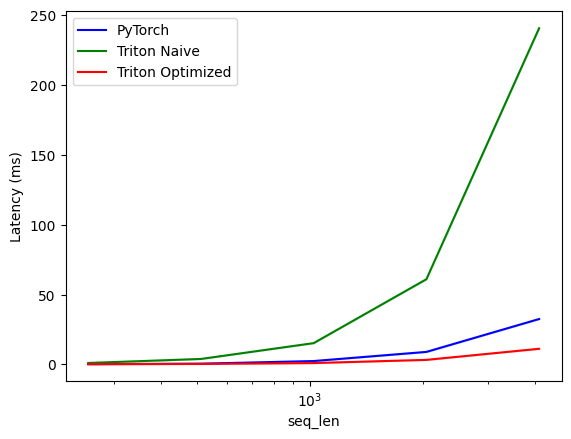

In [31]:
benchmark_attention.run(save_path='./attention_benchmark', print_data=True)

In [39]:
compare_memory_usage([256, 512, 1024, 2048, 4096])


Memory Usage Comparison:
--------------------------------------------------------------------------------
Seq Length   PyTorch (MB)    Triton Naive (MB)   
--------------------------------------------------------------------------------
256          66.50           67.25               
512          102.25          96.25               
1024         229.25          193.25              
2048         718.25          550.25              
4096         2632.25         1912.25             

Theoretical Attention Matrix Memory:
--------------------------------------------------------------------------------
Seq Length   Memory (MB)    
--------------------------------------------------------------------------------
256          3.00           
512          12.00          
1024         48.00          
2048         192.00         
4096         768.00         
